In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 28.3 MB/s 
     |████████████████████████████████| 6.6 MB 57.0 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 596 kB 68.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from tensorflow.keras.utils import to_categorical
from transformers import TFBertModel
from transformers import TFAutoModel
from tensorflow.keras import *
from tensorflow.keras import layers
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp '/content/drive/MyDrive/Question2_Data.zip' .

In [6]:
!unzip Question2_Data.zip

Archive:  Question2_Data.zip
   creating: Question2_Data/
  inflating: __MACOSX/._Question2_Data  
  inflating: Question2_Data/train.xlsx  
  inflating: __MACOSX/Question2_Data/._train.xlsx  
  inflating: Question2_Data/valid.xlsx  
  inflating: __MACOSX/Question2_Data/._valid.xlsx  
  inflating: Question2_Data/test.xlsx  
  inflating: __MACOSX/Question2_Data/._test.xlsx  


In [7]:
class DataLoader:
  def __init__(self,tokenizer):
    self.tokenizer = tokenizer
    self.train_df = pd.read_excel('Question2_Data/train.xlsx')
    self.test_df = pd.read_excel('Question2_Data/test.xlsx')
    self.valid_df = pd.read_excel('Question2_Data/valid.xlsx')
    self.label_encoder = LabelEncoder()

  def generate_data(self,data_type):
    if(data_type == 'mix'):
       x_train1,y_train,x_test1,y_test,x_valid1,y_valid = self.split_data('source')
       x_train2,y_train,x_test2,y_test,x_valid2,y_valid = self.split_data('targets')
       return zip(x_train1,x_train2),y_train,zip(x_test1,x_test2),y_test,zip(x_valid1,x_valid2),y_valid

    elif(data_type == 'persian'):
      return self.split_data('targets')

    return self.split_data('source')

  def split_data(self,column):
    x_train,y_train = self.train_df[column].values,to_categorical(self.label_encoder.fit_transform(self.train_df['category'].values),dtype = 'int32')
    x_test,y_test = self.test_df[column].values,to_categorical(self.label_encoder.transform(self.test_df['category'].values),dtype = 'int32')
    x_valid,y_valid = self.valid_df[column].values,to_categorical(self.label_encoder.transform(self.valid_df['category'].values),dtype = 'int32')
    return x_train,y_train,x_test,y_test,x_valid,y_valid

  def generate_bert_input(self,data,max_sequence_length=128):
    ids = []
    attn_masks = []
    for i,text in tqdm(enumerate(data)):
        tokenized_text = self.tokenizer.encode_plus(
            text,
            max_length = max_sequence_length,
            truncation = True,
            padding = 'max_length',
            add_special_tokens = True,
            return_tensors = 'tf'
        )
        ids.append(tokenized_text.input_ids[0])
        attn_masks.append(tokenized_text.attention_mask[0])
    return [np.array(ids),np.array(attn_masks)]


In [23]:
class Bert:

  def __init__(self,model_address,data_type):
    self.model_address = model_address
    self.data_type = data_type
    self.tokenizer = AutoTokenizer.from_pretrained(self.model_address)
    try:
      self.bert = TFAutoModel.from_pretrained(self.model_address)
    except:
      self.bert = TFAutoModel.from_pretrained(self.model_address,from_pt=True)
    self.data_loader = DataLoader(self.tokenizer)

  def createBERTModel(self,max_length=128):
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
  
    self.bert.trainable = True
    bert_output = self.bert(input_ids, attention_mask=attention_masks)
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    dropout = tf.keras.layers.Dropout(0.1)(pooled_output)
    output = layers.Dense(1024,activation="relu")(dropout)
    output = tf.keras.layers.Dense(3, activation="softmax")(output)
    self.model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks], outputs=output
    )
    #self.model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=3e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    print(self.model.summary())
    return self.model

  def train_model(self):
    self.model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=3e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    x_train,y_train,x_test,y_test,x_valid,y_valid = self.data_loader.generate_data(self.data_type)
    train_data = self.data_loader.generate_bert_input(x_train)
    valid_data = self.data_loader.generate_bert_input(x_valid)
    self.history = self.model.fit(train_data, y_train,validation_data=(valid_data,y_valid),epochs=10, batch_size = 32)

  def plot_accuracy(self):
    plt.plot(self.history.history['accuracy'],label='train')
    plt.plot(self.history.history['val_accuracy'],label='validation')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

  def eval_model(self):
    x_train,y_train,x_test,y_test,x_valid,y_valid = self.data_loader.generate_data(self.data_type)
    test_data = self.data_loader.generate_bert_input(x_test)
    predicted_y = self.model.predict(test_data)
    number_label_mapping = {0: 'bible', 1:'mizan',2:'quran'}
    y_test_conv = [number_label_mapping[np.argmax(val)] for val in y_test]
    predicted_y_conv = [number_label_mapping[np.argmax(val)] for val in predicted_y]
    print('Classification report:')
    print(classification_report(y_test_conv, predicted_y_conv))
    print('Accuracy:', accuracy_score(y_test_conv, predicted_y_conv))
    print('F1 (Micro):', f1_score(y_test_conv, predicted_y_conv, average='micro'))
    print('F1 (Macro):', f1_score(y_test_conv, predicted_y_conv, average='macro'))
    print('F1 (Weighted):', f1_score(y_test_conv, predicted_y_conv, average='weighted'))
    print('Recall (Micro):', recall_score(y_test_conv, predicted_y_conv, average='micro'))
    print('Recall (Macro):', recall_score(y_test_conv, predicted_y_conv, average='macro'))
    print('Recall (Weighted):', recall_score(y_test_conv, predicted_y_conv, average='weighted'))
    print('Precision (Micro):', precision_score(y_test_conv, predicted_y_conv, average='micro'))
    print('Precision (Macro):', precision_score(y_test_conv, predicted_y_conv, average='macro'))
    print('Precision (Weighted):', precision_score(y_test_conv, predicted_y_conv, average='weighted'))
    y_test_auc = [np.argmax(val) for val in y_test]
    print('AUC:', roc_auc_score(y_test_auc,predicted_y, multi_class='ovr'))

## part 1

In [24]:
bert_model = Bert('bert-base-uncased','english')
bert_model.createBERTModel()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [25]:
bert_model.train_model()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1/10
394/394 [==============================] - 340s 828ms/step - loss: 0.1943 - accuracy: 0.9249 - val_loss: 0.0868 - val_accuracy: 0.9696
Epoch 2/10
394/394 [==============================] - 329s 835ms/step - loss: 0.0528 - accuracy: 0.9823 - val_loss: 0.1154 - val_accuracy: 0.9678
Epoch 3/10
394/394 [==============================] - 329s 834ms/step - loss: 0.0168 - accuracy: 0.9948 - val_loss: 0.0994 - val_accuracy: 0.9737
Epoch 4/10
394/394 [==============================] - 328s 834ms/step - loss: 0.0100 - accuracy: 0.9967 - val_loss: 0.1242 - val_accuracy: 0.9704
Epoch 5/10
394/394 [==============================] - 329s 835ms/step - loss: 0.0130 - accuracy: 0.9954 - val_loss: 0.1142 - val_accuracy: 0.9726
Epoch 6/10
394/394 [==============================] - 329s 835ms/step - loss: 0.0146 - accuracy: 0.9950 - val_loss: 0.1105 - val_accuracy: 0.9767
Epoch 7/10
394/394 [==============================] - 329s 835ms/step - loss: 0.0087 - accuracy: 0.9971 - val_loss: 0.1099 -

0it [00:00, ?it/s]

Classification report:
              precision    recall  f1-score   support

       bible       0.96      0.99      0.97       900
       mizan       0.98      0.98      0.98       900
       quran       0.99      0.95      0.97       900

    accuracy                           0.98      2700
   macro avg       0.98      0.98      0.98      2700
weighted avg       0.98      0.98      0.98      2700

Accuracy: 0.975925925925926
F1 (Micro): 0.975925925925926
F1 (Macro): 0.9759068800565046
F1 (Weighted): 0.9759068800565045
Recall (Micro): 0.975925925925926
Recall (Macro): 0.975925925925926
Recall (Weighted): 0.975925925925926
Precision (Micro): 0.975925925925926
Precision (Macro): 0.9762602252227316
Precision (Weighted): 0.9762602252227316
AUC: 0.9980403292181069


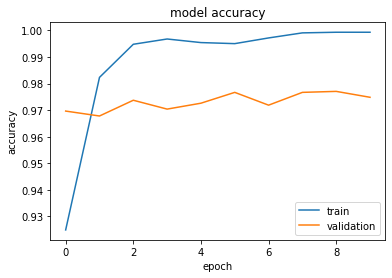

In [26]:
bert_model.eval_model()
bert_model.plot_accuracy()

## part 2

In [27]:
pars_model = Bert('HooshvareLab/bert-base-parsbert-uncased','persian')
pars_model.createBERTModel()

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/919M [00:00<?, ?B/s]

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  162841344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [28]:
pars_model.train_model()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1/10
394/394 [==============================] - 350s 853ms/step - loss: 0.1677 - accuracy: 0.9383 - val_loss: 0.0922 - val_accuracy: 0.9641
Epoch 2/10
394/394 [==============================] - 340s 862ms/step - loss: 0.0333 - accuracy: 0.9875 - val_loss: 0.0980 - val_accuracy: 0.9674
Epoch 3/10
394/394 [==============================] - 340s 862ms/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.1053 - val_accuracy: 0.9707
Epoch 4/10
394/394 [==============================] - 340s 862ms/step - loss: 0.0139 - accuracy: 0.9958 - val_loss: 0.1453 - val_accuracy: 0.9622
Epoch 5/10
394/394 [==============================] - 340s 863ms/step - loss: 0.0105 - accuracy: 0.9967 - val_loss: 0.1081 - val_accuracy: 0.9770
Epoch 6/10
394/394 [==============================] - 340s 863ms/step - loss: 0.0092 - accuracy: 0.9973 - val_loss: 0.1284 - val_accuracy: 0.9693
Epoch 7/10
394/394 [==============================] - 339s 862ms/step - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.1302 -

0it [00:00, ?it/s]

Classification report:
              precision    recall  f1-score   support

       bible       0.93      0.98      0.96       900
       mizan       0.98      0.92      0.95       900
       quran       0.97      0.97      0.97       900

    accuracy                           0.96      2700
   macro avg       0.96      0.96      0.96      2700
weighted avg       0.96      0.96      0.96      2700

Accuracy: 0.9592592592592593
F1 (Micro): 0.9592592592592593
F1 (Macro): 0.9591904391355786
F1 (Weighted): 0.9591904391355787
Recall (Micro): 0.9592592592592593
Recall (Macro): 0.9592592592592593
Recall (Weighted): 0.9592592592592593
Precision (Micro): 0.9592592592592593
Precision (Macro): 0.9601856549747781
Precision (Weighted): 0.960185654974778
AUC: 0.9973330246913581


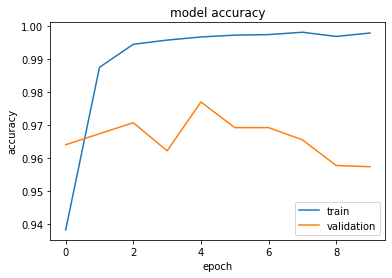

In [29]:
pars_model.eval_model()
pars_model.plot_accuracy()

## part 3

In [30]:
xlm_model = Bert('xlm-roberta-base','mix')
xlm_model.createBERTModel()

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tfxlm_roberta_model (TFXLMRobe  TFBaseModelOutputWi  278043648  ['input_ids[0][0]',              
 rtaModel)                      thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [31]:
xlm_model.train_model()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1/10
394/394 [==============================] - 382s 933ms/step - loss: 0.2311 - accuracy: 0.9089 - val_loss: 0.0463 - val_accuracy: 0.9867
Epoch 2/10
394/394 [==============================] - 365s 926ms/step - loss: 0.0342 - accuracy: 0.9901 - val_loss: 0.0313 - val_accuracy: 0.9926
Epoch 3/10
394/394 [==============================] - 365s 926ms/step - loss: 0.0243 - accuracy: 0.9926 - val_loss: 0.0374 - val_accuracy: 0.9896
Epoch 4/10
394/394 [==============================] - 365s 926ms/step - loss: 0.0301 - accuracy: 0.9911 - val_loss: 0.0225 - val_accuracy: 0.9915
Epoch 5/10
394/394 [==============================] - 365s 926ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0333 - val_accuracy: 0.9941
Epoch 6/10
394/394 [==============================] - 365s 927ms/step - loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.0847 - val_accuracy: 0.9833
Epoch 7/10
394/394 [==============================] - 365s 927ms/step - loss: 0.0198 - accuracy: 0.9948 - val_loss: 0.0383 -

0it [00:00, ?it/s]

Classification report:
              precision    recall  f1-score   support

       bible       1.00      0.99      0.99       900
       mizan       0.99      1.00      0.99       900
       quran       0.99      0.99      0.99       900

    accuracy                           0.99      2700
   macro avg       0.99      0.99      0.99      2700
weighted avg       0.99      0.99      0.99      2700

Accuracy: 0.9925925925925926
F1 (Micro): 0.9925925925925926
F1 (Macro): 0.9925925647384437
F1 (Weighted): 0.9925925647384437
Recall (Micro): 0.9925925925925926
Recall (Macro): 0.9925925925925926
Recall (Weighted): 0.9925925925925926
Precision (Micro): 0.9925925925925926
Precision (Macro): 0.9926002798629776
Precision (Weighted): 0.9926002798629775
AUC: 0.9995105967078189


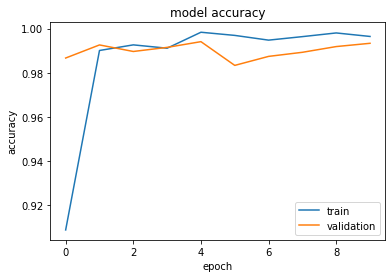

In [32]:
xlm_model.eval_model()
xlm_model.plot_accuracy()